## Visualizing CNNs
based on: https://github.com/utkuozbulak/pytorch-cnn-visualizations

In [2]:
from __future__ import print_function
from torch.autograd import Variable
import torch

xx = Variable(torch.ones(1), requires_grad = True)
yy = 6*xx  #
zz = yy**2 #
ww = zz*2  # 2 * 

xx.register_hook(print)
yy.register_hook(print)
zz.register_hook(print) # 2 * 3 ** 2
ww.register_hook(print) 
ww.backward()


 1
[torch.FloatTensor of size (1,)]


 2
[torch.FloatTensor of size (1,)]


 24
[torch.FloatTensor of size (1,)]


 144
[torch.FloatTensor of size (1,)]



In [124]:
import cv2
import numpy as np
import torch

from misc_functions import get_params, save_class_activation_on_image

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x # output of the layer & output of the network

class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_index=None):
        # Full forward pass
        # conv_output: output of convolutions at specified layer
        # model_output: final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)

        print(conv_output.shape, model_output.shape)
        # Layer: 0
        # torch.Size([1, 64, 55, 55]) torch.Size([1, 1000])
        
        # if no label is provided
        if target_index is None: target_index = np.argmax(model_output.data.numpy())
        
        # Target for backprop: labeling
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_index] = 1
        
        # Zero grads: reset gradients
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)

        # Get hooked gradients (on the specific layer)
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        print('guided_gradients: ', np.min(guided_gradients), np.max(guided_gradients))
        print('guided_gradients: ', guided_gradients.shape)
        # guided_gradients: (64, 55, 55)

        # Get convolution outputs: activation map
        target = conv_output.data.numpy()[0]
        print('am', np.min(target), np.max(target))
        
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        print('weights (mean of gradients)', np.min(weights), np.max(weights))

        print('weights shape: ', weights.shape)
        # weights shape:  (64,)
            
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        
        print('HERE input_image: ', np.min(input_image.data.numpy()), np.max(input_image.data.numpy()))
        print('HERE gradients: ', np.min(guided_gradients), np.max(guided_gradients))
        print('HERE am: ', np.min(target), np.max(target))
        print('HERE weights: ', np.min(weights), np.max(weights))
        
        print('cam shape: ', cam.shape)
        # cam shape:  (55, 55)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        print('cam (mean of gradients * am): ', np.min(cam), np.max(cam))

        print('cam shape: ', cam.shape)
        # cam shape:  (55, 55)
        cam = cv2.resize(cam, (224, 224))
        print('cam (mean of gradients * am): ', np.min(cam), np.max(cam))


        cam = np.maximum(cam, 0)
        print('cam (mean of gradients * am): ', np.min(cam), np.max(cam))

        
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        print('cam (mean of gradients * am): ', np.min(cam), np.max(cam))

        
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        print('cam (mean of gradients * am): ', np.min(cam), np.max(cam))

        
        print('cam shape: ', cam.shape)
        # cam shape:  (224, 224)
        return cam

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_params(target_example)

# grad_cam = GradCam(pretrained_model, target_layer=11)
# cam = grad_cam.generate_cam(prep_img, target_class)
# save_class_activation_on_image(original_image, cam, file_name_to_export)
# print('Grad cam completed')

In [125]:
import sys
sys.path.append('/blanca/workspace/blanca/utils')
import libraries
from utils_global import *
%matplotlib inline

print(original_image.shape, prep_img.shape, target_class, file_name_to_export)
print(pretrained_model)

(224, 224, 3) torch.Size([1, 3, 224, 224]) 56 snake
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (

In [126]:
# ## CAM GENERATION
# print(np.min(cam_color), np.max(cam_color)) 
# print(np.min(original_image), np.max(original_image)) 

# cam_color_ = np.float32(cam_color) / np.max(cam_color)
# original_image_ = np.float32(original_image) / np.max(original_image)

# print(np.min(cam_color_), np.max(cam_color_))
# print(np.min(original_image_), np.max(original_image_)) 

# im_ = np.multiply(cam_color_, original_image_)
# print(np.min(im_), np.max(im_)) 

# print(cam_color.shape, original_image.shape, im_.shape)

Layer: 0
torch.Size([1, 64, 55, 55]) torch.Size([1, 1000])
guided_gradients:  -0.0564731 0.0814772
guided_gradients:  (64, 55, 55)
am 0.0 29.8777
weights (mean of gradients) -0.000524517 0.000851275
weights shape:  (64,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0564731 0.0814772
HERE am:  0.0 29.8777
HERE weights:  -0.000524517 0.000851275
cam shape:  (55, 55)
cam (mean of gradients * am):  0.994019 1.0103
cam shape:  (55, 55)
cam (mean of gradients * am):  0.994508 1.00919
cam (mean of gradients * am):  0.994508 1.00919
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


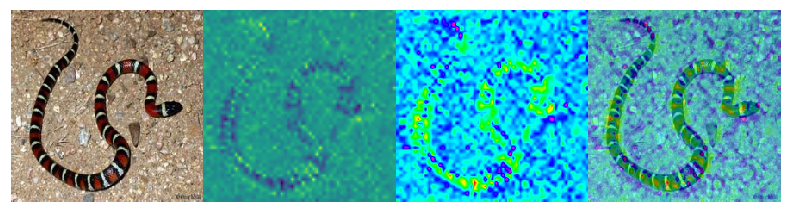

Layer: 1
torch.Size([1, 64, 55, 55]) torch.Size([1, 1000])
guided_gradients:  -0.0564731 0.0814772
guided_gradients:  (64, 55, 55)
am 0.0 29.8777
weights (mean of gradients) -0.000615738 0.000851275
weights shape:  (64,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0564731 0.0814772
HERE am:  0.0 29.8777
HERE weights:  -0.000615738 0.000851275
cam shape:  (55, 55)
cam (mean of gradients * am):  0.991604 1.01016
cam shape:  (55, 55)
cam (mean of gradients * am):  0.99268 1.00895
cam (mean of gradients * am):  0.99268 1.00895
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


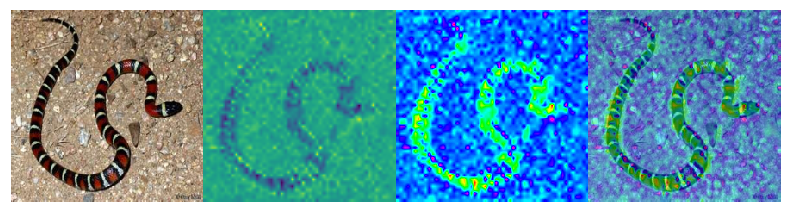

Layer: 2
torch.Size([1, 64, 27, 27]) torch.Size([1, 1000])
guided_gradients:  -0.0430737 0.0630402
guided_gradients:  (64, 27, 27)
am 0.0 29.8777
weights (mean of gradients) -0.00255502 0.00353238
weights shape:  (64,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0430737 0.0630402
HERE am:  0.0 29.8777
HERE weights:  -0.00255502 0.00353238
cam shape:  (27, 27)
cam (mean of gradients * am):  0.957652 1.04929
cam shape:  (27, 27)
cam (mean of gradients * am):  0.959108 1.04914
cam (mean of gradients * am):  0.959108 1.04914
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


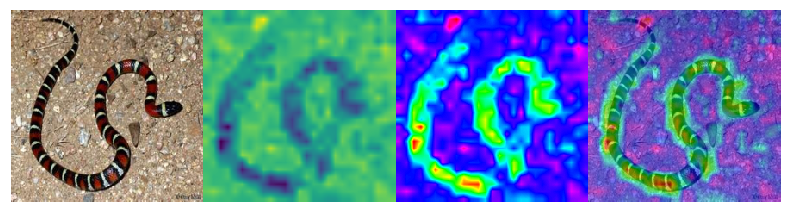

Layer: 3
torch.Size([1, 192, 27, 27]) torch.Size([1, 1000])
guided_gradients:  -0.0282212 0.0249595
guided_gradients:  (192, 27, 27)
am 0.0 43.3493
weights (mean of gradients) -0.00036187 0.000349244
weights shape:  (192,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0282212 0.0249595
HERE am:  0.0 43.3493
HERE weights:  -0.00036187 0.000349244
cam shape:  (27, 27)
cam (mean of gradients * am):  0.98881 1.01675
cam shape:  (27, 27)
cam (mean of gradients * am):  0.989211 1.01646
cam (mean of gradients * am):  0.989211 1.01646
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


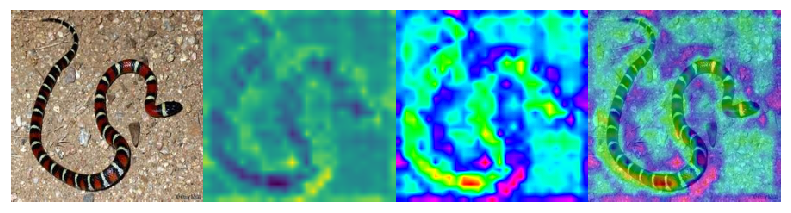

Layer: 4
torch.Size([1, 192, 27, 27]) torch.Size([1, 1000])
guided_gradients:  -0.0282212 0.0249595
guided_gradients:  (192, 27, 27)
am 0.0 43.3493
weights (mean of gradients) -0.000805294 0.000487624
weights shape:  (192,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0282212 0.0249595
HERE am:  0.0 43.3493
HERE weights:  -0.000805294 0.000487624
cam shape:  (27, 27)
cam (mean of gradients * am):  0.976133 1.0208
cam shape:  (27, 27)
cam (mean of gradients * am):  0.976344 1.01984
cam (mean of gradients * am):  0.976344 1.01984
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


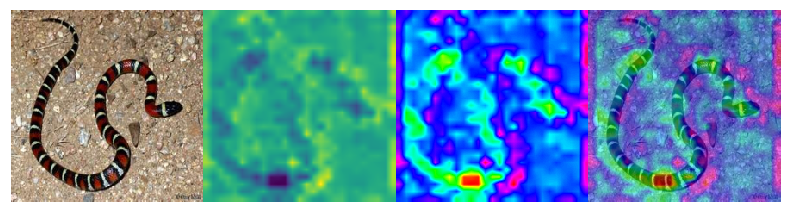

Layer: 5
torch.Size([1, 192, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0146675 0.0163619
guided_gradients:  (192, 13, 13)
am 0.0 43.3493
weights (mean of gradients) -0.00347372 0.00210342
weights shape:  (192,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0146675 0.0163619
HERE am:  0.0 43.3493
HERE weights:  -0.00347372 0.00210342
cam shape:  (13, 13)
cam (mean of gradients * am):  0.793267 1.11969
cam shape:  (13, 13)
cam (mean of gradients * am):  0.796276 1.11778
cam (mean of gradients * am):  0.796276 1.11778
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


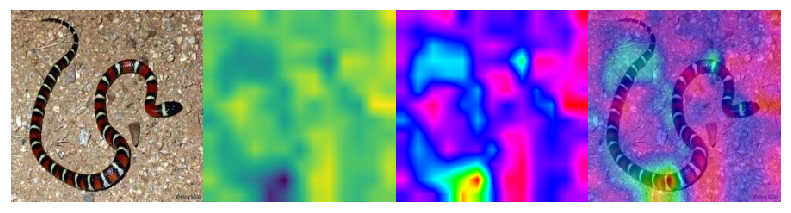

Layer: 6
torch.Size([1, 384, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0132373 0.0125887
guided_gradients:  (384, 13, 13)
am 0.0 48.303
weights (mean of gradients) -0.000687383 0.00147687
weights shape:  (384,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0132373 0.0125887
HERE am:  0.0 48.303
HERE weights:  -0.000687383 0.00147687
cam shape:  (13, 13)
cam (mean of gradients * am):  0.997592 1.08394
cam shape:  (13, 13)
cam (mean of gradients * am):  0.997819 1.08283
cam (mean of gradients * am):  0.997819 1.08283
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


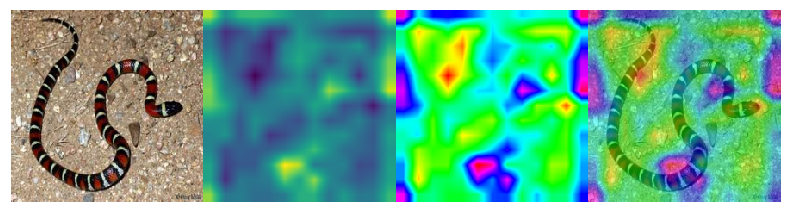

Layer: 7
torch.Size([1, 384, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0162503 0.0161786
guided_gradients:  (384, 13, 13)
am 0.0 48.303
weights (mean of gradients) -0.0027876 0.00321957
weights shape:  (384,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0162503 0.0161786
HERE am:  0.0 48.303
HERE weights:  -0.0027876 0.00321957
cam shape:  (13, 13)
cam (mean of gradients * am):  0.898983 1.19104
cam shape:  (13, 13)
cam (mean of gradients * am):  0.899227 1.18778
cam (mean of gradients * am):  0.899227 1.18778
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


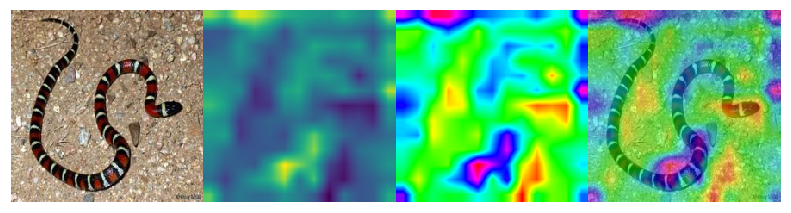

Layer: 8
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0184256 0.0210588
guided_gradients:  (256, 13, 13)
am 0.0 39.3305
weights (mean of gradients) -0.0010034 0.00291974
weights shape:  (256,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0184256 0.0210588
HERE am:  0.0 39.3305
HERE weights:  -0.0010034 0.00291974
cam shape:  (13, 13)
cam (mean of gradients * am):  0.98638 1.19118
cam shape:  (13, 13)
cam (mean of gradients * am):  0.986921 1.18639
cam (mean of gradients * am):  0.986921 1.18639
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


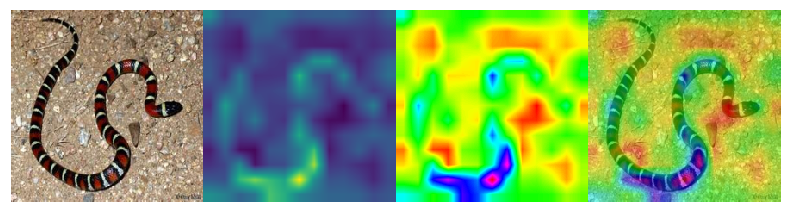

Layer: 9
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0184256 0.0210588
guided_gradients:  (256, 13, 13)
am 0.0 39.3305
weights (mean of gradients) -0.00529397 0.00617534
weights shape:  (256,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0184256 0.0210588
HERE am:  0.0 39.3305
HERE weights:  -0.00529397 0.00617534
cam shape:  (13, 13)
cam (mean of gradients * am):  0.847254 1.25538
cam shape:  (13, 13)
cam (mean of gradients * am):  0.850806 1.24514
cam (mean of gradients * am):  0.850806 1.24514
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


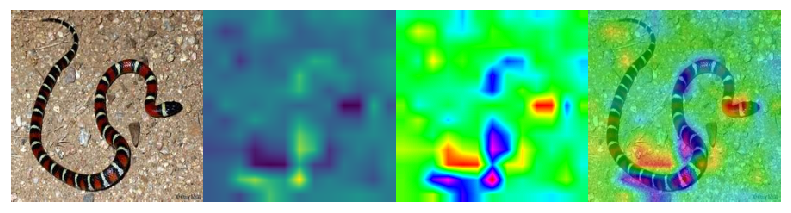

Layer: 10
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0425266 0.089026
guided_gradients:  (256, 13, 13)
am 0.0 29.7573
weights (mean of gradients) -0.00130482 0.00544117
weights shape:  (256,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0425266 0.089026
HERE am:  0.0 29.7573
HERE weights:  -0.00130482 0.00544117
cam shape:  (13, 13)
cam (mean of gradients * am):  1.00645 1.13615
cam shape:  (13, 13)
cam (mean of gradients * am):  1.00705 1.13615
cam (mean of gradients * am):  1.00705 1.13615
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


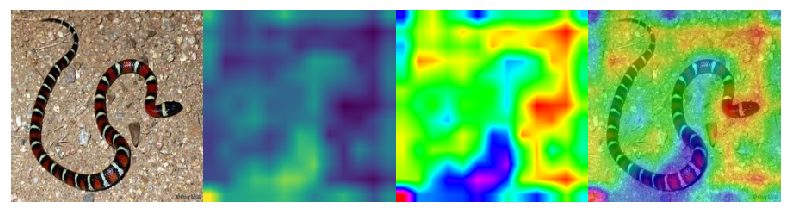

Layer: 11
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients:  -0.0425266 0.089026
guided_gradients:  (256, 13, 13)
am 0.0 29.7573
weights (mean of gradients) -0.00272045 0.00595951
weights shape:  (256,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.0425266 0.089026
HERE am:  0.0 29.7573
HERE weights:  -0.00272045 0.00595951
cam shape:  (13, 13)
cam (mean of gradients * am):  1.00839 1.15317
cam shape:  (13, 13)
cam (mean of gradients * am):  1.00909 1.15317
cam (mean of gradients * am):  1.00909 1.15317
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


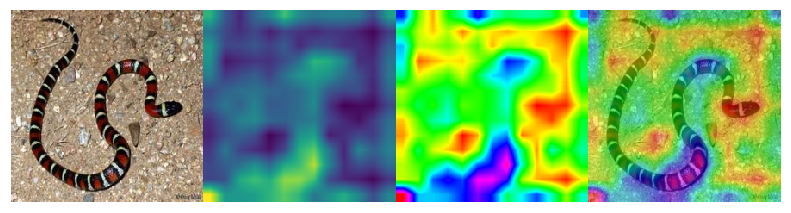

Layer: 12
torch.Size([1, 256, 6, 6]) torch.Size([1, 1000])
guided_gradients:  -0.020659 0.033807
guided_gradients:  (256, 6, 6)
am 0.0 29.7573
weights (mean of gradients) -0.012771 0.0279766
weights shape:  (256,)
HERE input_image:  -2.1179 2.64
HERE gradients:  -0.020659 0.033807
HERE am:  0.0 29.7573
HERE weights:  -0.012771 0.0279766
cam shape:  (6, 6)
cam (mean of gradients * am):  1.31619 2.1671
cam shape:  (6, 6)
cam (mean of gradients * am):  1.31747 2.16576
cam (mean of gradients * am):  1.31747 2.16576
cam (mean of gradients * am):  0.0 1.0
cam (mean of gradients * am):  0 255
cam shape:  (224, 224)


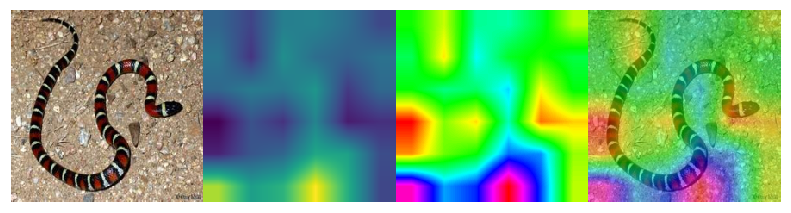

In [127]:
for i in pretrained_model.features._modules.keys(): 
    print('Layer:', i)
    grad_cam = GradCam(pretrained_model, target_layer=int(i))
    cam = grad_cam.generate_cam(prep_img, target_class)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
    im_with_cam_color = np.float32(cam_color) + np.float32(original_image)    
    im_with_cam_color = im_with_cam_color / np.max(im_with_cam_color)
    
    ims = [original_image, cam, cam_color, im_with_cam_color * 255]
    plot_ims(ims)

In [41]:
## GUIDED BACKPROP

In [71]:
import torch
from torch.nn import ReLU
from misc_functions import (get_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, processed_im, target_class):
        self.model = model
        self.input_image = processed_im
        self.target_class = target_class
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that it only returns positive gradients
        """
        def relu_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, changes it to zero
            """
            if isinstance(module, ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)
        # Loop through layers, hook up ReLUs with relu_hook_function
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_hook_function)

    def generate_gradients(self):
        # Forward pass
        model_output = self.model(self.input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][self.target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [72]:
## EXAMPLE OF GRADIENTS WITH BACKPROP

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_params(target_example)

# Guided backprop
GBP = GuidedBackprop(pretrained_model, prep_img, target_class)
# Get gradients
guided_grads = GBP.generate_gradients()
# Save colored gradients
# save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
# save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps

pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
# save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
# save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

Guided backprop completed


Data dimensions not supported
Data dimensions not supported


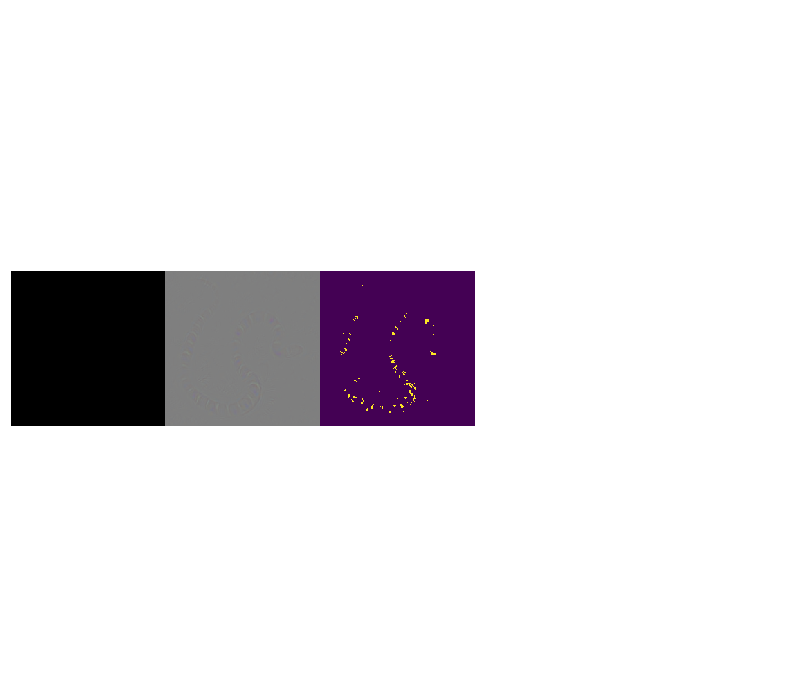

In [73]:
im_guided_grads = guided_grads.transpose((1, 2, 0))  #* 255
im_guided_grads_norm = ((guided_grads.transpose((1, 2, 0)) / 2) + 0.5) *255
im_grayscale_guided_grads = grayscale_guided_grads[0] #.transpose((1, 2, 0)) #* 255
im_pos_sal = pos_sal.transpose((1, 2, 0)) * 255
im_neg_sal = neg_sal.transpose((1, 2, 0)) * 255

ims = [im_guided_grads, im_guided_grads_norm, im_grayscale_guided_grads, pos_sal, neg_sal]
plot_ims(ims)

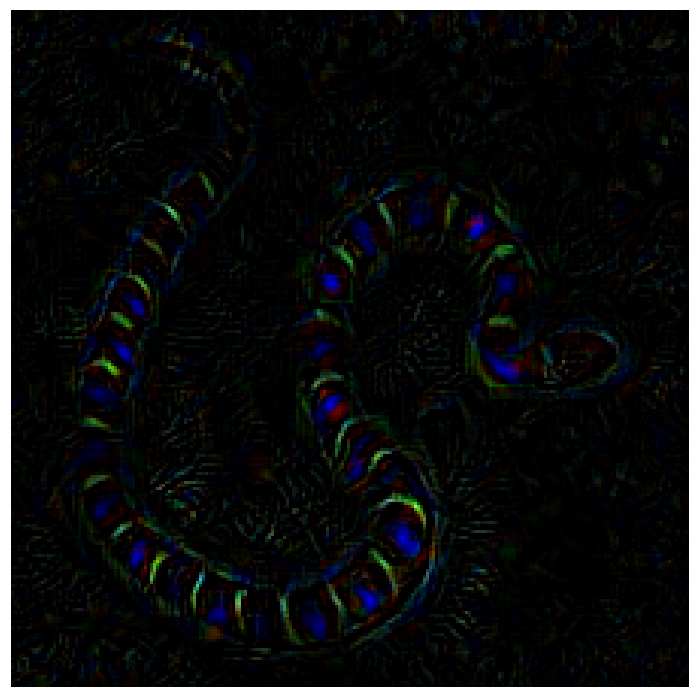

In [74]:
im_guided_grads = ((guided_grads.transpose((1, 2, 0)) * 255))
# print(np.max(im_guided_grads))

im_guided_grads = ((guided_grads.transpose((1, 2, 0)) / 2) + 0.5) *255
# print(np.max(im_guided_grads))

im_pos_sal = pos_sal.transpose((1, 2, 0)) * 255
plot_im(im_pos_sal)

In [105]:
from misc_functions import convert_to_grayscale, save_gradient_images
from guided_backprop import GuidedBackprop

def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask

    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_params(target_example)

gcv2 = GradCam(pretrained_model, target_layer=11)
cam = gcv2.generate_cam(prep_img, target_class)
print('Grad cam completed')

GBP = GuidedBackprop(pretrained_model, prep_img, target_class)
guided_grads = GBP.generate_gradients()
print('Guided backpropagation completed')

cam_gb = guided_grad_cam(cam, guided_grads)
#     save_gradient_images(cam_gb, file_name_to_export + '_GGrad_Cam')
#     grayscale_cam_gb = convert_to_grayscale(cam_gb)
#     save_gradient_images(grayscale_cam_gb, file_name_to_export + '_GGrad_Cam_gray')
#     print('Guided grad cam completed')

torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
Grad cam completed
Guided backpropagation completed


In [124]:
# plot_im(cam_gb.transpose((1, 2, 0)))
guided_grads.shape
np.max(guided_grads)

0.10540352

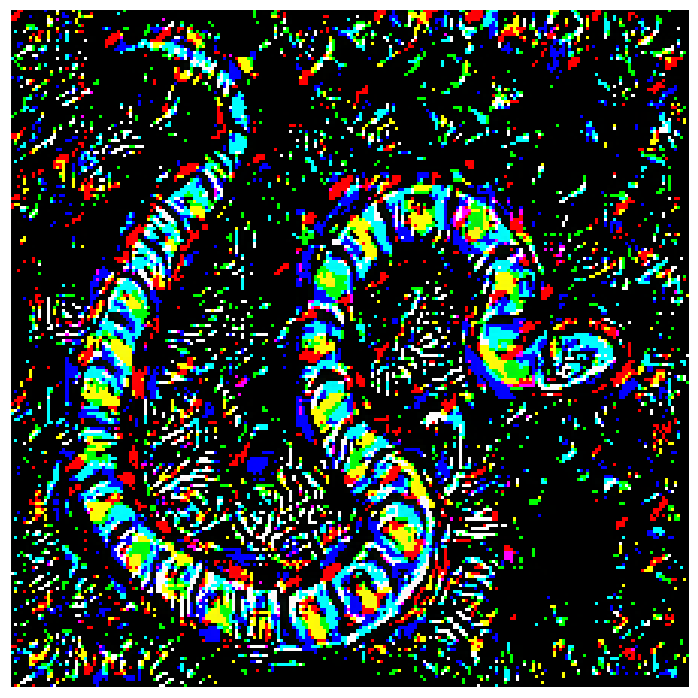

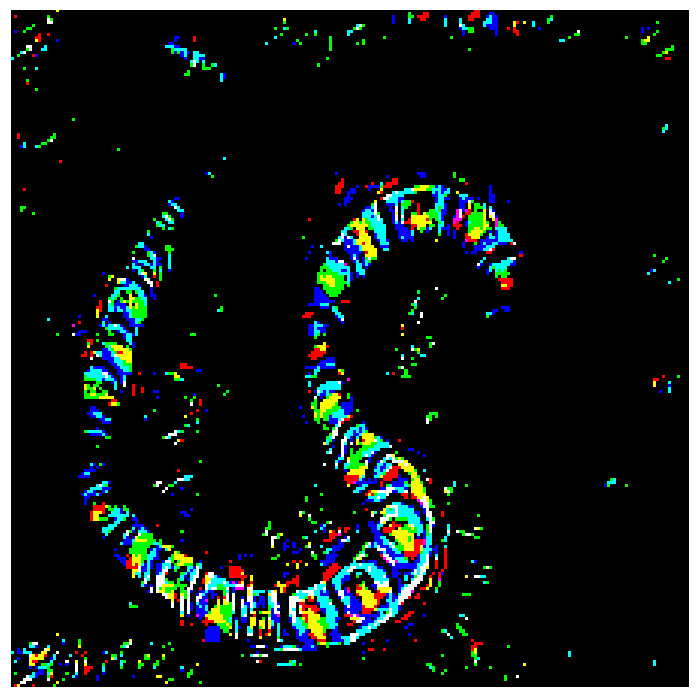

In [129]:
plot_im((255 * guided_grads).transpose((1, 2, 0)))
plot_im(cam_gb.transpose((1, 2, 0)))

In [5]:
import sys
from importlib import reload
sys.path.append('/blanca/workspace/blanca/utils')
import libraries
import utils_global
reload(utils_global)

from utils_global import *
%matplotlib inline

## TESTING IN P2PHD DISCRIMINATOR
import torch
import torch.nn as nn
import functools
from networks import *
import sys
# project_models_path = '/media/dataserver/workspace/blanca/project/wip/pix2pixHDX-class-master/models'
# project_models_path = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/models'

di_v_path = '/blanca'
project_path = 'workspace/blanca/project/wip/pix2pixHDX-class-master'
sys.path.append(os.path.join(di_v_path, project_path))

from models import networks_utils as networks

In [6]:
# VIS GAN
D_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/test_X/200_net_D.pth'
G_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/test_X/200_net_G.pth'
G_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/clean_G_class_10_D/100_net_G.pth'
D_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/clean_G_class_10_D/100_net_D.pth'

def define_G(input_nc, output_nc, ngf, n_downsample_global=4, n_blocks_global=9, n_local_enhancers=1,
             n_blocks_local=3, norm='instance'):

    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    netG = GlobalGenerator(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, norm_layer)
    return netG

def define_D(input_nc, ndf, n_layers_D, norm='instance', use_sigmoid=False, num_D=2, getIntermFeat=True):
    
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    netD = MultiscaleDiscriminator(input_nc, ndf, n_layers_D, norm_layer, use_sigmoid, num_D, getIntermFeat)
    return netD

input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, n_local_enhancers, n_blocks_local = 3, 3, 64, 4, 9, 1, 3
netG = define_G(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, n_local_enhancers, n_blocks_local)
netG.load_state_dict(torch.load(G_MODEL_PATH))

input_nc, ndf, n_layers_D, num_D = 6, 64, 3, 2
netD = define_D(input_nc, ndf, n_layers_D, num_D)
netD.load_state_dict(torch.load(D_MODEL_PATH))

criterionGAN = networks.GANLoss(use_lsgan=True, tensor=torch.Tensor)

In [7]:
netD

MultiscaleDiscriminator(
  (scale0_layer0): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(0.2, inplace)
  )
  (scale0_layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(0.2, inplace)
  )
  (scale0_layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(0.2, inplace)
  )
  (scale0_layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(0.2, inplace)
  )
  (scale0_layer4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (scal

In [8]:
# import importlib
# importlib.reload(data)

from data.base_dataset import BaseDataset, get_params, get_transform, normalize
from data.base_dataset import fill_gaps, read_image_OpenCV, resize_image_OpenCV, load_original_mask

from data.image_folder import make_dataset
# custom functions
from data.image_folder import create_dataset, create_dataset_withLabel, create_dataset_fromIDsubfolders, create_dataset_fromIDsubfolders_withLabel 

import os.path
import torch
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path

class Options():
    def __init__(self):
        self.dataroot = '/blanca/workspace/blanca/training_datasets/pix2pix/'
        self.dataset_list = ['images_target_clean_classified', 'video_target_clean_classified']
        self.isTrain = True
        self.label_nc = 0
        self.output_nc = 3
        self.loadSize = 256
        self.fill = 'W&B'
        self.no_lsgan = False
    
class AlignedDataset(BaseDataset):
        
    def initialize(self, opt):
        self.opt = opt
        self.root = opt.dataroot    
        self.dataset_list = opt.dataset_list

        self.target_paths = []
        if self.opt.isTrain:
            self.target_paths += create_dataset_withLabel(os.path.join(self.root, self.dataset_list[0])); print(len(self.target_paths))
            self.target_paths += create_dataset_fromIDsubfolders_withLabel(os.path.join(self.root, self.dataset_list[1]), nitems=2); print(len(self.target_paths))
        else:
            # self.target_paths += create_dataset(os.path.join(self.root, self.dataset_list[0]))
            self.target_paths += make_dataset(os.path.join(self.root, self.dataset_list[0])); print(self.target_paths)
            
        self.dataset_size = len(self.target_paths) 
        
        if True: 
            self.images_mask_path = Path('../../../training_datasets/pix2pix/images_mask')
            self.images_mask_fname_list = [i.parts[-1] for i in list(self.images_mask_path.glob('*.png'))]
            
    def apply_data_transforms(self, im, which, opt, nchannels=None):
        
        transform_list = []
        if which == 'target':
            transform_list += [
                    transforms.Lambda(lambda x: fill_gaps(x, opt, fill_input_with='average')),
                    transforms.Lambda(lambda x: x[:, :, :nchannels]),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ]
                
        elif which == 'targetXC':
             transform_list += [
                    transforms.Lambda(lambda x: x[:, :, :nchannels]),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ]
    
        elif which == 'input':        
            transform_list += [
                transforms.Lambda(lambda x: x.copy()),
                transforms.Lambda(lambda x: fill_gaps(x, opt, add_artificial=opt.isTrain)),
                # drops the compose&blended image alpha channel and loads the original one:
                transforms.Lambda(lambda x: load_original_mask(x, nchannels == 4, opt,
                                                               self.target_path, 
                                                               self.images_mask_fname_list, 
                                                               self.images_mask_path)),
                transforms.Lambda(lambda x: x[:, :, :nchannels]),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ]
            
        elif which == 'mask':        
            transform_list += [
                transforms.Lambda(lambda x: x.copy()),
                transforms.Lambda(lambda x: load_original_mask(x, nchannels == 4, opt,
                                                               self.target_path,
                                                               self.images_mask_fname_list,
                                                               self.images_mask_path)),
                transforms.Lambda(lambda x: fill_gaps(x, opt, only_extract_mask=True)),
                # transforms.Lambda(lambda x: resize_image_OpenCV(x, (224, 224))),

                transforms.Lambda(lambda x: x[:, :, 3]),
                    ]                                    
                                         
        return transforms.Compose(transform_list)(im)
    
    
    def __getitem__(self, index):                             
        
        target_tensor = target_label_tensor = inst_tensor = feat_tensor = target4C_tensor = target_mask_tensor = 0
        
        input_nc = self.opt.label_nc if self.opt.label_nc != 0 else 3
        output_nc = self.opt.output_nc
        
        # read target image
        if self.opt.isTrain:
                self.target_path = self.target_paths[index][0]
                target_label = self.target_paths[index][1]
        else: self.target_path = self.target_paths[index]
                
        target_im = read_image_OpenCV(self.target_path, self.opt)
        target_im_resized = read_image_OpenCV(self.target_path, self.opt, target_size=(224, 224))
                
        # create input tensor first
        # if self.opt.isTrain:
        input_tensor = self.apply_data_transforms(target_im, 'input', self.opt, input_nc)
        # just for visualization purposes (check that the original alpha channel is loaded properly):
        input_mask_tensor = self.apply_data_transforms(target_im, 'mask', self.opt, input_nc)  
        
        # create output tensor
        if self.opt.isTrain: 
                
                # target image (image label) for the GAN
                target_tensor = self.apply_data_transforms(target_im, 'target', self.opt, output_nc)
                # target image with alpha channel
                target4C_tensor = self.apply_data_transforms(target_im_resized, 'targetXC', self.opt, nchannels=4)
                # good/bad fit label
                target_label_tensor = torch.FloatTensor([target_label])
                
                # delete?:
                # target image alpha channel to append to the output of G, and before entering the classifier
                # target_mask_tensor = self.apply_data_transforms(target_im, 'mask', self.opt)
        
        input_dict = {'input': input_tensor, 'inst': inst_tensor, 
                      'target': target_tensor, 'feat': feat_tensor, 
                      'target4C': target4C_tensor, 'input_mask': input_mask_tensor,
                      'path': self.target_path, 'label': target_label_tensor}

        return input_dict
    
    def __get_x_item__(self, index):
        return self.__getitem__(index)
    
    def __len__(self):
        return len(self.target_paths)

    def name(self):
        return 'AlignedDataset'

# load and tansform image
im_path = '/workspace/blanca/training_datasets/pix2pix/images_target_clean_classified/bad_fit/300w01_indoor_015.png'
im_path = os.path.join(di_v_path, im_path)

opt = Options()
dataset =  AlignedDataset()
dataset.initialize(opt)

# data_loader = CreateDataLoader(opt)
# dataset = data_loader.load_data()
# dataset_size = len(data_loader)
# print('#training images = %d' % dataset_size)

x = dataset.__get_x_item__(0)

shuffling...done
shuffling...done
shuffling...done
2222
Total found IDs in path /blanca/workspace/blanca/training_datasets/pix2pix/video_target_clean_classified/good_fit: 49 .. and selected 2 per ID
shuffling...done
2326


In [83]:
# def preprocess_image(cv2im, resize_im=True):
#     """
#         Processes image for CNNs

#     Args:
#         PIL_img (PIL_img): Image to process
#         resize_im (bool): Resize to 224 or not
#     returns:
#         im_as_var (Pytorch variable): Variable that contains processed float tensor
#     """
#     # mean and std list for channels (Imagenet)
#     mean = [0.485, 0.456, 0.406]
#     std = [0.229, 0.224, 0.225]
#     # Resize image
#     if resize_im:
#         cv2im = cv2.resize(cv2im, (224, 224))
#     im_as_arr = np.float32(cv2im)
#     im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
#     im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
#     # Normalize the channels
#     for channel, _ in enumerate(im_as_arr):
#         im_as_arr[channel] /= 255
#         im_as_arr[channel] -= mean[channel]
#         im_as_arr[channel] /= std[channel]
#     # Convert to float tensor
#     im_as_ten = torch.from_numpy(im_as_arr).float()
#     # Add one more channel to the beginning. Tensor shape = 1,3,224,224
#     im_as_ten.unsqueeze_(0)
#     # Convert to Pytorch variable
#     im_as_var = Variable(im_as_ten, requires_grad=True)
#     return im_as_var

input
inst
target
feat
target4C
input_mask
path
label
(256, 256, 3) (256, 256, 3) (256, 256)


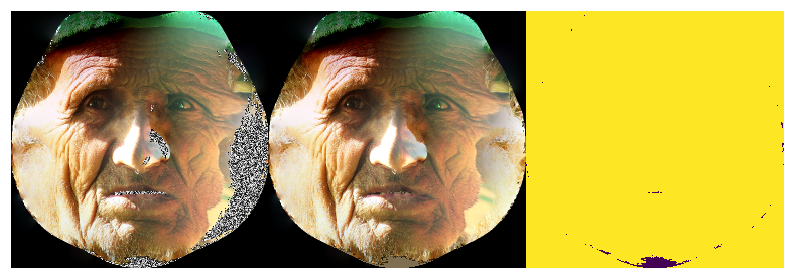

In [172]:
x = dataset.__get_x_item__(5)
for k, v in x.items(): print(k)

im_input = ((x['input'].data.numpy().transpose((1, 2, 0)) / 2) + 0.5) * 255
im_target = ((x['target'].data.numpy().transpose((1, 2, 0)) / 2) + 0.5) * 255
im_mask = x['input_mask']

print(im_input.shape, im_target.shape, im_mask.shape)
plot_ims([im_input, im_target, im_mask], alpha=True)

In [173]:
x_input = x['input'].expand(1, x['input'].shape[0], x['input'].shape[1], x['input'].shape[2])
x_target = x['target'].expand(1, x['target'].shape[0], x['target'].shape[1], x['target'].shape[2])

print(x_input.shape, x_target.shape)

input_D = torch.cat((x_input, x_target), dim=1)

print(type(input_D), input_D.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
<class 'torch.autograd.variable.Variable'> torch.Size([1, 6, 256, 256])


In [174]:
output_D = netD(input_D)

# output of the discriminator is a list len == numD
# each D provides an output of size 5
print(len(output_D[0]), len(output_D[1]))
output = output_D[0][0].data.cpu().numpy()

output_D[0][0].shape

## D1
# torch.Size([1, 64, 129, 129])
# torch.Size([1, 128, 65, 65])
# torch.Size([1, 256, 33, 33])
# torch.Size([1, 512, 34, 34])
# torch.Size([1, 1, 35, 35])

## D2
# torch.Size([1, 64, 65, 65])
# torch.Size([1, 128, 33, 33])
# torch.Size([1, 256, 17, 17])
# torch.Size([1, 512, 18, 18])
# torch.Size([1, 1, 19, 19])

## Loss
# self.fc = nn.Linear(d*2, 1)

5 5


torch.Size([1, 64, 129, 129])

In [175]:
i_a = output_D[0][3]
avgpool_D1 = nn.AvgPool2d(i_a.shape[-1], stride=1)
fc = nn.Linear(i_a.shape[1], 1)
o_a = avgpool_D1(i_a)
i_fc = o_a.view(o_a.size(0), -1)
o_fc = fc(i_fc)

print(i_a.shape, o_a.shape, o_fc.shape)

outsm = nn.functional.sigmoid(o_fc)

w = torch.mm(outsm, Variable(fc.weight.data))
w.shape

cam = torch.mul(i_a, w.unsqueeze(2).unsqueeze(3))
cam = cam.sum(1).unsqueeze(1)

# x1 = o_a
# x1 = x1.view(x1.size(0), -1)
# print(x1.shape)
# outsm = F.sigmoid(self.fc(x1))

# w = torch.mm(outsm, Variable(self.fc.weight.data))

#         cam = torch.mul(x, w.unsqueeze(2).unsqueeze(3))
#         cam = cam.sum(1).unsqueeze(1)
#         # print("OK")
#         # print("outputCAM size is {}".format(self.upsample(cam).shape))
#         return outsm, self.upsample(cam)

print(w.unsqueeze(2).shape)
print(w.unsqueeze(2).unsqueeze(3).shape)

# plot_im(cam.data.numpy()[0][0] * 255)
cam.data.numpy()[0][0].shape

torch.Size([1, 512, 34, 34]) torch.Size([1, 512, 1, 1]) torch.Size([1, 1])
torch.Size([1, 512, 1])
torch.Size([1, 512, 1, 1])


(34, 34)

None
scale1_layer0 0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
(64, 129, 129) torch.Size([1, 1, 35, 35]) torch.Size([1, 64, 129, 129])
activation map shape:  (64, 129, 129)
weights shape:  (64,)
cam shape:  (129, 129)
HERE output:  -0.861437 6.36756
HERE input_image:  -1.0 1.0
HERE gradients:  -0.878372 1.44749
HERE am:  -0.861437 6.36756
HERE weights:  -0.00095404 0.00159986
HERE 0.997722 1.03766
HERE 0.997722 1.03766
HERE 0.0 1.0
HERE 0 255
HERE 0.0104909 1.22284
HERE 0.0104909 1.22284
HERE 0.0 1.0
HERE 0 255


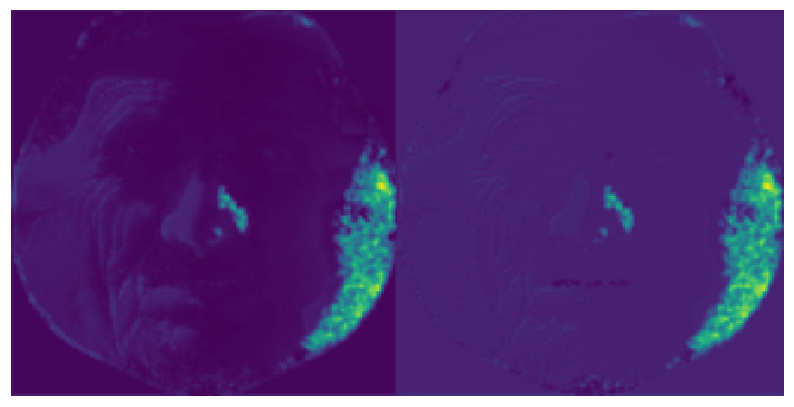

In [178]:
# model = netD
# num_D = 2
# for i in range(netD.num_D):
#     model = [getattr(netD, 'scale' + str(num_D - 1 - i) + '_layer' + str(j)) for j in range(netD.n_layers + 2)]
#     setattr(netD, 'last_layer_%d' %i, model[-1]._modules['0'])

# netD.last_layer_0.weight.shape

## FORWARD PASS ON CONV LAYERS
model = netD

gradients = {}
def save_gradient(layer_name): 
    def save(grad):
        gradients[layer_name] = grad
    return save


x = input_D
conv_output = None
for block_name, block in model._modules.items():
    for module_pos, module in block._modules.items():
        if block_name[:6] == 'scale1':
#             print(block_name[:6], module_pos)
            x = module(x)
            if block_name == 'scale1_layer0' and module_pos == '0':
                x.register_hook(save_gradient(block_name))
                x.retain_grad(); print(x.grad)
                conv_output = x  # Save the convolution output on that layer
                print(block_name, module_pos, module)

# x = x.view(x.size(0), -1)  # Flatten
# print(x.shape)
# Forward pass on the classifier
# x = self.model.classifier(x)
                
# print(x.shape, x, conv_output.shape)

label_code = 1.0
label = torch.FloatTensor(x.size()).fill_(label_code)
label = Variable(label, requires_grad=True)

x.backward(gradient=label, retain_graph=True)
gradients = gradients['scale1_layer0'].data.numpy()[0]

print(gradients.shape, x.shape, conv_output.shape)
# (512,34,34)

## CAM
am = conv_output.data.numpy()[0]
print('activation map shape: ', am.shape)
# activation map shape: (512, 34, 34)
weights = np.mean(gradients, axis=(1, 2))  
print('weights shape: ', weights.shape)
# weights shape:  (512,)            
cam = np.ones(am.shape[1:], dtype=np.float32)
print('cam shape: ', cam.shape)
# cam shape: (34, 34)

print('HERE output: ', np.min(output), np.max(output))
print('HERE input_image: ', np.min(input_D.data.numpy()), np.max(input_D.data.numpy()))
print('HERE gradients: ', np.min(gradients), np.max(gradients))
print('HERE am: ', np.min(am), np.max(am))
print('HERE weights: ', np.min(weights), np.max(weights))

# multiply each weight with its conv output and then, sum
for i, w in enumerate(weights):
    cam += w * am[i, :, :]
#     print('HERE update to cam', w, np.min(w * am[i, :, :]), np.max(w * am[i, :, :]))
#     print('HERE', np.min(cam), np.max(cam))
    
cam = cv2.resize(cam, (224, 224))
print('HERE', np.min(cam), np.max(cam))
cam = np.maximum(cam, 0)
print('HERE', np.min(cam), np.max(cam))
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
print('HERE', np.min(cam), np.max(cam))
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
print('HERE', np.min(cam), np.max(cam))

# print('cam shape: ', cam.shape)
# cam shape:  (224, 224)


# upsample = nn.Upsample(scale_factor=4, mode = "bilinear")

# x = upsample(x); print(x.shape)
# x = upsample(x); print(x.shape)
# x = x.data.numpy()[0][0]

# HERE input_image:  -2.1179 2.64
# HERE gradients:  -0.0564731 0.0814772
# HERE am:  0.0 29.8777
# HERE weights:  -0.000524517 0.000851275

am = np.mean(am, axis=0) 
am = cv2.resize(am, (224, 224))

print('HERE', np.min(am), np.max(am))
am = np.maximum(am, 0)
print('HERE', np.min(am), np.max(am))
am = (am - np.min(am)) / (np.max(am) - np.min(am))  # Normalize between 0-1
print('HERE', np.min(am), np.max(am))
am = np.uint8(am * 255)  # Scale between 0-255 to visualize
print('HERE', np.min(am), np.max(am))
plot_ims([am, cam])

In [87]:
model = pretrained_model   
target_layer = 11
conv_output = None
# x = image
for module_pos, module in model.features._modules.items():
    print(module_pos, module)
#     x = module(x)  # Forward
#     if int(module_pos) == target_layer:
#         print(module_pos)
#         x.register_hook(self.save_gradient)
#         conv_output = x  # Save the convolution output on that layer


0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
1 ReLU(inplace)
2 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
4 ReLU(inplace)
5 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 ReLU(inplace)
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 ReLU(inplace)
10 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace)
12 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)


In [208]:
model = netD
for block_name, block in model._modules.items():
    for module_pos, module in block._modules.items():
        print(block_name, module_pos, module)
        if not isinstance(module, torch.nn.modules.activation.LeakyReLU): 
            if module.weight is not None: print(module.weight.shape)

scale0_layer0 0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
torch.Size([64, 6, 4, 4])
scale0_layer0 1 LeakyReLU(0.2, inplace)
scale0_layer1 0 Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
torch.Size([128, 64, 4, 4])
scale0_layer1 1 InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
scale0_layer1 2 LeakyReLU(0.2, inplace)
scale0_layer2 0 Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
torch.Size([256, 128, 4, 4])
scale0_layer2 1 InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
scale0_layer2 2 LeakyReLU(0.2, inplace)
scale0_layer3 0 Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
torch.Size([512, 256, 4, 4])
scale0_layer3 1 InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
scale0_layer3 2 LeakyReLU(0.2, inplace)
scale0_layer4 0 Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
torch.Size(

In [ ]:
## VISUALIZING DENSENET with 80% accuracy

In [ ]:
# # one_hot_output
# label = networks_utils.GANLoss().get_target_tensor(x , True)
# print(label, type(label))

# # is the same as..
# label_code = 1.0
# label = torch.FloatTensor(x.size()).fill_(label_code)
# label_var = Variable(label, requires_grad=False)

# print(label, label_var, type(label), type(label_var)) 